Descobrindo novos materiais usando Inteligência Artificial (e aprendendo algo novo no processo)
===============================================================================================

**Autor:** Daniel R. Cassar



## Parte 0 - Avisos, instalações e importações



1.  Estrutura do notebook

2.  Python

3.  Comentários e dúvidas no final de cada parte

4.  Módulos básicos: `numpy`, `scipy`, `pandas` e `matplotlib`

5.  Módulos específicos: `scikit-learn`, `pymoo`, `shap` e `glasspy`



In [93]:
import sys

!{sys.executable} -m pip install pymoo==0.6.0.1
!{sys.executable} -m pip install shap==0.42.1
!{sys.executable} -m pip install glasspy==0.4.4

'c:\Program' n�o � reconhecido como um comando interno
ou externo, um programa oper�vel ou um arquivo em lotes.
'c:\Program' n�o � reconhecido como um comando interno
ou externo, um programa oper�vel ou um arquivo em lotes.
'c:\Program' n�o � reconhecido como um comando interno
ou externo, um programa oper�vel ou um arquivo em lotes.


In [94]:
import numpy as np
import pandas as pd
import shap
from matplotlib import pyplot as plt
from scipy.stats import randint

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn import tree
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import export_text

from pymoo.core.problem import ElementwiseProblem, Problem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.termination import get_termination
from pymoo.optimize import minimize

from glasspy.predict import GlassNet
from glasspy.chemistry import to_array
from glasspy.data import SciGlass

<hr>



## Parte 1 - Dados



Banco de dados SciGlass

1.  Histórico / criadores

2.  Estatísticas

3.  Licença Open Database [https://github.com/epam/SciGlass](https://github.com/epam/SciGlass)



### Carregando dados do SciGlass usando `GlassPy`



O módulo `GlassPy` já tem os dados do SciGlass e já carrega eles em DataFrames de `pandas`.

Na primeira vez que rodamos temos que baixar os dados do servidor, isso pode demorar uns minutos. Fora isso, toda vez que você carregar os dados, o `GlassPy` deve ler as tabelas do SciGlass e processá-las. Isto também leva um certo tempo.



In [95]:
sciglass = SciGlass()

df = sciglass.data
df

elements                                                         \
                     H   Li   Be         B    C    N         O    F        Na   
ID                                                                              
20400020000        0.0  0.0  0.0  0.000000  0.0  0.0  0.666667  0.0  0.000000   
20500020001        0.0  0.0  0.0  0.000000  0.0  0.0  0.579213  0.0  0.196815   
20500020002        0.0  0.0  0.0  0.000000  0.0  0.0  0.580869  0.0  0.193449   
20500020003        0.0  0.0  0.0  0.000000  0.0  0.0  0.581986  0.0  0.187167   
20500020004        0.0  0.0  0.0  0.000000  0.0  0.0  0.583672  0.0  0.183080   
...                ...  ...  ...       ...  ...  ...       ...  ...       ...   
4493300611694      0.0  0.0  0.0  0.000000  0.0  0.0  0.625485  0.0  0.000000   
4493300611695      0.0  0.0  0.0  0.001948  0.0  0.0  0.637540  0.0  0.000000   
4493300611696      0.0  0.0  0.0  0.000000  0.0  0.0  0.635921  0.0  0.000000   
4493300611697      0.0  0.0  0.0  0.014544  0.0  0.0  0.622226  0.0  0.035890   
4493300611698      0.0  0.0  0.0  0.041532  0.0  0.0  0.634462  0.0  0.000000   

                         ...              property                      \
                     Mg  ... SurfaceTensionAboveTg SurfaceTension1173K   
ID                       ...                                             
20400020000    0.000000  ...                   NaN                 NaN   
20500020001    0.000000  ...                   NaN                 NaN   
20500020002    0.000000  ...                   NaN                 NaN   
20500020003    0.000000  ...                   NaN                 NaN   
20500020004    0.000000  ...                   NaN                 NaN   
...                 ...  ...                   ...                 ...   
4493300611694  0.049125  ...                   NaN                 NaN   
4493300611695  0.009932  ...                   NaN                 NaN   
4493300611696  0.000000  ...                   NaN                 NaN   
4493300611697  0.000000  ...                   NaN                 NaN   
4493300611698  0.000487  ...                   NaN                 NaN   

                                                                           \
              SurfaceTension1473K SurfaceTension1573K SurfaceTension1673K   
ID                                                                          
20400020000                   NaN                 NaN                 NaN   
20500020001                   NaN                 NaN                 NaN   
20500020002                   NaN                 NaN                 NaN   
20500020003                   NaN                 NaN                 NaN   
20500020004                   NaN                 NaN                 NaN   
...                           ...                 ...                 ...   
4493300611694                 NaN                 NaN                 NaN   
4493300611695                 NaN                 NaN                 NaN   
4493300611696                 NaN                 NaN                 NaN   
4493300611697                 NaN                 NaN                 NaN   
4493300611698                 NaN                 NaN                 NaN   

                      metadata                                        \
              ChemicalAnalysis           Author  Year NumberElements   
ID                                                                     
20400020000              False  Volarovich M.P.  1936              2   
20500020001              False         Hoj J.W.  1992              5   
20500020002              False         Hoj J.W.  1992              5   
20500020003              False         Hoj J.W.  1992              5   
20500020004              False         Hoj J.W.  1992              5   
...                        ...              ...   ...            ...   
4493300611694            False        Murata T.  2019              7   
4493300611695            False        Murat

### Informações disponíveis e seu significado



Metadados:

-   `ChemicalAnalysis`: Indicates if the glass composition was obtained by chemical analysis
-   `Author`: First author of the publication
-   `Year`: Year of the publication

Propriedades:

-   `T0`: Temperature where viscosity is 1 Pa.s (K)
-   `T1`: Temperature where viscosity is 10 Pa.s (K)
-   `T2`: Temperature where viscosity is 100 Pa.s (K)
-   `T3`: Temperature where viscosity is 1000 Pa.s (K)
-   `T4`: Temperature where viscosity is 10000 Pa.s (K)
-   `T5`: Temperature where viscosity is 100000 Pa.s (K)
-   `T6`: Temperature where viscosity is 1000000 Pa.s (K)
-   `T7`: Temperature where viscosity is 10000000 Pa.s (K)
-   `T8`: Temperature where viscosity is 100000000 Pa.s (K)
-   `T9`: Temperature where viscosity is 1000000000 Pa.s (K)
-   `T10`: Temperature where viscosity is 10000000000 Pa.s (K)
-   `T11`: Temperature where viscosity is 100000000000 Pa.s (K)
-   `T12`: Temperature where viscosity is 1000000000000 Pa.s (K)
-   `Viscosity773K`: Viscosity at 773 K (Pa.s)
-   `Viscosity873K`: Viscosity at 873 K (Pa.s)
-   `Viscosity973K`: Viscosity at 973 K (Pa.s)
-   `Viscosity1073K`: Viscosity at 1073 K (Pa.s)
-   `Viscosity1173K`: Viscosity at 1173 K (Pa.s)
-   `Viscosity1273K`: Viscosity at 1273 K (Pa.s)
-   `Viscosity1373K`: Viscosity at 1373 K (Pa.s)
-   `Viscosity1473K`: Viscosity at 1473 K (Pa.s)
-   `Viscosity1573K`: Viscosity at 1573 K (Pa.s)
-   `Viscosity1673K`: Viscosity at 1673 K (Pa.s)
-   `Viscosity1773K`: Viscosity at 1773 K (Pa.s)
-   `Viscosity1873K`: Viscosity at 1873 K (Pa.s)
-   `Viscosity2073K`: Viscosity at 2073 K (Pa.s)
-   `Viscosity2273K`: Viscosity at 2273 K (Pa.s)
-   `Viscosity2473K`: Viscosity at 2473 K (Pa.s)
-   `Tg`: Glass transition temperature (K)
-   `Tmelt`: Melting temperature (K)
-   `Tliquidus`: Liquidus temperature (K)
-   `TLittletons`: Littletons softening temperature (K)
-   `TAnnealing`: Annealing point (K)
-   `Tstrain`: Strain point (K)
-   `Tsoft`: Softening point (K)
-   `TdilatometricSoftening`: Dilatometric softening temperature (K)
-   `AbbeNum`: Abbe&rsquo;s number
-   `RefractiveIndex`: Refractive index
-   `RefractiveIndexLow`: Refractive index measured at a wavelenght between 0.6 and 1 micron at 293 K
-   `RefractiveIndexHigh`: Refractive index measured at a wavelenght greater than 1 micron at 293 K
-   `MeanDispersion`: Mean dispersion (nF - nC)
-   `Permittivity`: Relative permittivity at ambient temperature anf frequency of1 MHz (or the nearest frequency in the range of 0.01 MHz to 10 MHz)
-   `TangentOfLossAngle`: Tangent of loss angle
-   `TresistivityIs1MOhm.m`: Temperature where the specific electrical resistivity is 1MOhm.m (K)
-   `Resistivity273K`: Specific electrical resistivity measured at 273 K (Ohm.m)
-   `Resistivity373K`: Specific electrical resistivity measured at 373 K (Ohm.m)
-   `Resistivity423K`: Specific electrical resistivity measured at 423 K (Ohm.m)
-   `Resistivity573K`: Specific electrical resistivity measured at 573 K (Ohm.m)
-   `Resistivity1073K`: Specific electrical resistivity measured at 1073 K (Ohm.m)
-   `Resistivity1273K`: Specific electrical resistivity measured at 1273 K (Ohm.m)
-   `Resistivity1473K`: Specific electrical resistivity measured at 1473 K (Ohm.m)
-   `Resistivity1673K`: Specific electrical resistivity measured at 1673 K (Ohm.m)
-   `YoungModulus`: Young&rsquo;s Modulus (GPa)
-   `ShearModulus`: Shear Modulus (GPa)
-   `Microhardness`: Microhardness measured by Knoop or Vickers indentation (GPa)
-   `PoissonRatio`: Poisson&rsquo;s ratio
-   `Density293K`: Density measured at 293 K (g/cm3)
-   `Density1073K`: Density measured at 1073 K (g/cm3)
-   `Density1273K`: Density measured at 1273 K (g/cm3)
-   `Density1473K`: Density measured at 1473 K (g/cm3)
-   `Density1673K`: Density measured at 1673 K (g/cm3)
-   `ThermalConductivity`: Thermal conductivity (W/(m.K))
-   `ThermalShockRes`: Thermal shock resistance (K)
-   `CTEbelowTg`: Linear coefficient of thermal expansion measured below the glass transition temperature (1/K)
-   `CTE328K`: Linear coefficient of thermal expansion measured at 328 +/- 10 K (1/K)
-   `CTE373K`: Linear coefficient of thermal expansion measured at 373 +/- 10 K (1/K)
-   `CTE433K`: Linear coefficient of thermal expansion measured at 433 +/- 10 K (1/K)
-   `CTE483K`: Linear coefficient of thermal expansion measured at 483 +/- 10 K (1/K)
-   `CTE623K`: Linear coefficient of thermal expansion measured at 623 +/- 10 K (1/K)
-   `Cp293K`: Heat capacity at constant pressure measured at 293 K (J/(kg.K))
-   `Cp473K`: Heat capacity at constant pressure measured at 473 K (J/(kg.K))
-   `Cp673K`: Heat capacity at constant pressure measured at 673 K (J/(kg.K))
-   `Cp1073K`: Heat capacity at constant pressure measured at 1073 K (J/(kg.K))
-   `Cp1273K`: Heat capacity at constant pressure measured at 1273 K (J/(kg.K))
-   `Cp1473K`: Heat capacity at constant pressure measured at 1473 K (J/(kg.K))
-   `Cp1673K`: Heat capacity at constant pressure measured at 1673 K (J/(kg.K))
-   `NucleationTemperature`: Nucleation temperature (K)
-   `NucleationRate`: Crystal nucleation rate (1/(s.m3))
-   `TMaxGrowthVelocity`: Temperature of maximum crystal growth velocity (K)
-   `MaxGrowthVelocity`: Maximum crystal growth velocity (m/s)
-   `CrystallizationPeak`: DTA temperature of crystallization peak (K)
-   `CrystallizationOnset`: DTA temperature of crystallization onset (K)
-   `SurfaceTensionAboveTg`: Surface tension above the glass transition temperature (J/m2)
-   `SurfaceTension1173K`: Surface tension at 1173 K (J/m2)
-   `SurfaceTension1473K`: Surface tension at 1473 K (J/m2)
-   `SurfaceTension1573K`: Surface tension at 1573 K (J/m2)
-   `SurfaceTension1673K`: Surface tension at 1673 K (J/m2)



### Estrutura da tabela



O DataFrame está estruturado em dois níveis. No primeiro nível temos informação agrupada por composição, propriedade e metadados.



In [96]:
df.columns.levels[0]

Index(['elements', 'compounds', 'property', 'metadata'], dtype='object')

Veja na célula abaixo como explorar a composição química elementar dos vidros.



In [97]:
elementos = df["elements"]
elementos

,H,Li,Be,B,C,N,O,F,Na,Mg,...,W,Re,Pt,Au,Hg,Tl,Pb,Bi,Th,U
ID,,,,,,,,,,,,,,,,,,,,,
20400020000,0.0,0.0,0.0,0.000000,0.0,0.0,0.666667,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20500020001,0.0,0.0,0.0,0.000000,0.0,0.0,0.579213,0.0,0.196815,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20500020002,0.0,0.0,0.0,0.000000,0.0,0.0,0.580869,0.0,0.193449,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20500020003,0.0,0.0,0.0,0.000000,0.0,0.0,0.581986,0.0,0.187167,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20500020004,0.0,0.0,0.0,0.000000,0.0,0.0,0.583672,0.0,0.183080,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4493300611694,0.0,0.0,0.0,0.000000,0.0,0.0,0.625485,0.0,0.000000,0.049125,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4493300611695,0.0,0.0,0.0,0.001948,0.0,0.0,0.637540,0.0,0.000000,0.009932,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4493300611696,0.0,0.0,0.0,0.000000,0.0,0.0,0.635921,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Veja na célula abaixo como explorar uma coluna específica dentro do grupo de propriedades.



In [98]:
propriedade = df["property"]["Tg"]
propriedade

ID
20400020000          NaN
20500020001      1017.15
20500020002      1096.15
20500020003      1013.15
20500020004      1013.15
                  ...   
4493300611694        NaN
4493300611695        NaN
4493300611696        NaN
4493300611697        NaN
4493300611698        NaN
Name: Tg, Length: 283102, dtype: float64

Com o `pandas` podemos fazer uma análise exploratória dos dados.



[]

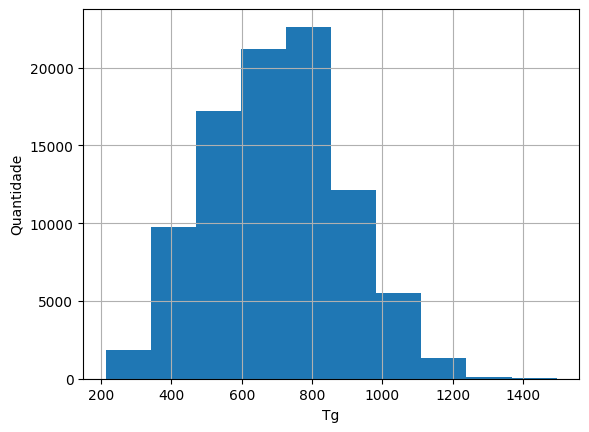

In [99]:
eixo = df["property"]["Tg"].hist()
eixo.set_xlabel("Tg")
eixo.set_ylabel("Quantidade")
eixo.plot()

Text(0, 0.5, 'Quantidade')

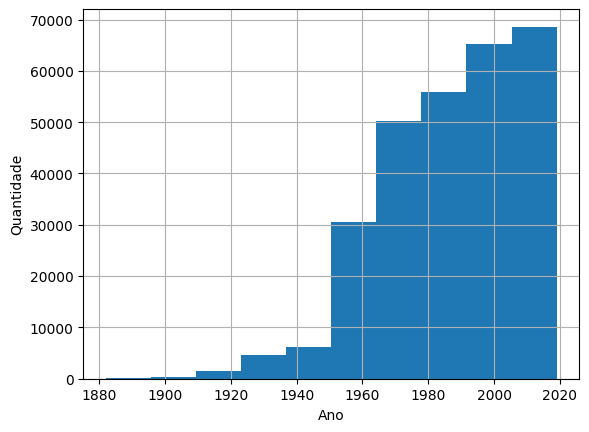

In [100]:
eixo = df["metadata"]["Year"].hist()
eixo.set_xlabel("Ano")
eixo.set_ylabel("Quantidade")

### Controlando a coleta de dados



Na maioria dos casos nós temos interesse em filtrar os dados considerando certas restrições.



In [101]:
ELEMENTOS_INTERESSE = ["Si", "O", "Ca", "Mg", "K", "Li", "Na", "Al"]
PROPRIEDADE_INTERESSE = "Tg"

In [102]:
elementos = ["H", "He", "Li", "Be", "B", "C", "N", "O", "F", "Ne",
             "Na", "Mg", "Al", "Si", "P", "S", "Cl", "Ar", "K", "Ca", "Sc",
             "Ti", "V", "Cr", "Mn", "Fe", "Co", "Ni", "Cu", "Zn", "Ga", "Ge",
             "As", "Se", "Br", "Kr", "Rb", "Sr", "Y", "Zr", "Nb", "Mo", "Tc",
             "Ru", "Rh", "Pd", "Ag", "Cd", "In", "Sn", "Sb", "Te", "I", "Xe",
             "Cs", "Ba", "La", "Ce", "Pr", "Nd", "Pm", "Sm", "Eu", "Gd", "Tb",
             "Dy", "Ho", "Er", "Tm", "Yb", "Lu", "Hf", "Ta", "W", "Re", "Os",
             "Ir", "Pt", "Au", "Hg", "Tl", "Pb", "Bi", "Po", "At", "Rn", "Fr",
             "Ra", "Ac", "Th", "Pa", "U", "Np", "Pu"]

elementos_indesejados = elementos.copy()

for item in ELEMENTOS_INTERESSE:
    elementos_indesejados.remove(item)

propriedades_indesejadas = sciglass.available_properties()

propriedades_indesejadas.remove(PROPRIEDADE_INTERESSE)

In [103]:
config_elementos = {
    "dropline": elementos_indesejados,
    "return_weight": False,
    "final_sum": 100,
}

config_propriedades = {
    "keep": [PROPRIEDADE_INTERESSE],
    "dropline": propriedades_indesejadas,
}

config_compostos = {
    "return_weight": False,
    "final_sum": 100,
    "dropline": elementos,
}

sg = SciGlass(
    elements_cfg=config_elementos,
    properties_cfg=config_propriedades,
    compounds_cfg=config_compostos,
)

sg.remove_duplicate_composition(
    scope="compounds",
    decimals=1,
    aggregator="median",
)

df = sg.data.droplevel(0, axis=1)
df

,SiO2,Al2O3,CaO,K2O,Na2O,Li2O,MgO,Tg
0,60.0,16.0,8.0,16.0,0.0,0.0,0.0,1044.15
1,60.0,16.0,8.0,12.8,3.2,0.0,0.0,985.15
2,60.0,16.0,8.0,9.6,6.4,0.0,0.0,946.15
3,60.0,16.0,8.0,6.4,9.6,0.0,0.0,927.15
4,60.0,16.0,8.0,3.2,12.8,0.0,0.0,925.15
...,...,...,...,...,...,...,...,...
2922,60.1,1.2,19.3,0.0,19.4,0.0,0.0,947.15
2923,67.2,2.6,4.0,0.6,14.3,0.0,11.3,822.15
2924,50.0,30.0,0.0,0.0,0.0,20.0,0.0,964.15
2925,63.0,0.0,8.0,12.0,10.0,0.0,7.0,754.15


O processo acima já remove dados duplicados (problema do vazamento de dados).



### Exportando o DataFrame para uma tabela de Excel



In [104]:
NOME_DO_ARQUIVO = "minha_tabela"

df.to_excel(f"{NOME_DO_ARQUIVO}.xlsx")

### Separando os atributos e target



In [105]:
X = df.drop(PROPRIEDADE_INTERESSE, axis=1)
y = df.reindex([PROPRIEDADE_INTERESSE], axis=1)

Vamos ver o que obtivemos.



In [106]:
X

,SiO2,Al2O3,CaO,K2O,Na2O,Li2O,MgO
0,60.0,16.0,8.0,16.0,0.0,0.0,0.0
1,60.0,16.0,8.0,12.8,3.2,0.0,0.0
2,60.0,16.0,8.0,9.6,6.4,0.0,0.0
3,60.0,16.0,8.0,6.4,9.6,0.0,0.0
4,60.0,16.0,8.0,3.2,12.8,0.0,0.0
...,...,...,...,...,...,...,...
2922,60.1,1.2,19.3,0.0,19.4,0.0,0.0
2923,67.2,2.6,4.0,0.6,14.3,0.0,11.3
2924,50.0,30.0,0.0,0.0,0.0,20.0,0.0
2925,63.0,0.0,8.0,12.0,10.0,0.0,7.0


In [107]:
y

,Tg
0,1044.15
1,985.15
2,946.15
3,927.15
4,925.15
...,...
2922,947.15
2923,822.15
2924,964.15
2925,754.15


### Divisão dos dados em treino e teste



Para medir a performance de um modelo, precisamos de dados que ele nunca tenha visto. A estratégia abaixo é a conhecida como split de treino e teste.



In [108]:
TAMANHO_TESTE = 0.1        # fração de dados reservada para teste
SEMENTE_ALEATORIA = 61455  # escolha um número inteiro positivo qualquer

indices = df.index
indices_treino, indices_teste = train_test_split(
    indices, test_size=TAMANHO_TESTE, random_state=SEMENTE_ALEATORIA
)

df_treino = df.loc[indices_treino]
df_teste = df.loc[indices_teste]

X_treino = df_treino.drop(PROPRIEDADE_INTERESSE, axis=1)
y_treino = df_treino.reindex([PROPRIEDADE_INTERESSE], axis=1)

X_teste = df_teste.drop(PROPRIEDADE_INTERESSE, axis=1)
y_teste = df_teste.reindex([PROPRIEDADE_INTERESSE], axis=1)

Vamos ver o que obtivemos para os atributos e target de treino.



In [109]:
X_treino

,SiO2,Al2O3,CaO,K2O,Na2O,Li2O,MgO
2686,73.0,17.0,6.0,0.0,0.0,4.0,0.0
2434,50.0,0.0,10.0,0.0,0.0,40.0,0.0
2799,66.2,8.8,25.0,0.0,0.0,0.0,0.0
913,62.3,18.6,12.8,0.0,6.3,0.0,0.0
840,5.0,38.0,57.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
403,73.5,0.0,0.0,26.5,0.0,0.0,0.0
2256,67.7,4.9,5.4,7.6,4.9,0.0,9.5
2480,66.7,10.8,0.6,2.4,13.2,0.0,6.2
2556,57.0,10.0,0.5,1.5,19.0,0.0,12.0


In [110]:
y_treino

,Tg
2686,1057.15
2434,703.15
2799,1059.15
913,1105.15
840,1133.65
...,...
403,751.15
2256,884.15
2480,863.15
2556,862.15


Vamos ver o que obtivemos para os atributos e target de teste.



In [111]:
X_teste

,SiO2,Al2O3,CaO,K2O,Na2O,Li2O,MgO
1618,73.0,0.0,13.0,0.0,14.0,0.0,0.0
2547,61.0,11.5,0.3,1.5,18.5,0.0,7.2
1603,57.7,4.0,34.6,3.7,0.0,0.0,0.0
345,63.0,7.4,11.1,0.0,18.5,0.0,0.0
2293,72.9,6.6,10.9,0.3,2.8,3.7,2.8
...,...,...,...,...,...,...,...
1842,76.0,0.0,0.0,0.0,14.0,0.0,10.0
2276,65.9,6.6,13.5,0.4,5.4,4.0,4.2
1055,21.0,31.6,47.4,0.0,0.0,0.0,0.0
1176,55.0,18.0,27.0,0.0,0.0,0.0,0.0


In [112]:
y_teste

,Tg
1618,828.15
2547,869.15
1603,1043.15
345,838.15
2293,898.15
...,...
1842,798.15
2276,857.15
1055,1131.15
1176,1104.15


Por fim, agora que terminamos de usar o `pandas`, vamos converter estas variáveis em arrays de `numpy`.



In [113]:
X_treino = X_treino.values
y_treino = y_treino.values.ravel()
X_teste = X_teste.values
y_teste = y_teste.values.ravel()

<hr>



## Parte 2 - Treinando um modelo



1.  Existem diversos algoritmos de aprendizado de máquina supervisionado

2.  Existem dois tipos de problemas supervisionados: regressão e classificação

3.  Durante o treino de um modelo, o algoritmo é apresentado aos dados de treino (tanto atributos quanto target)

4.  A performance do modelo treinado pode ser estimada utilizando os dados de teste

5.  Uma métrica usual para estimar a performance de modelos de regressão é o RMSE

$$
\mathrm{RMSE} = \sqrt{\sum_{i=1}^{N} \frac{(y_i - \hat{y}_i)^2}{N}}.
$$



### Treinando um modelo preditivo tipo árvore de decisão



#### O que é uma árvore de decisão?



1.  Árvores de decisão são grafos direcionais acíclicos.

2.  Árvores de decisão são modelos interpretáveis!



Minha árvore de decisão:


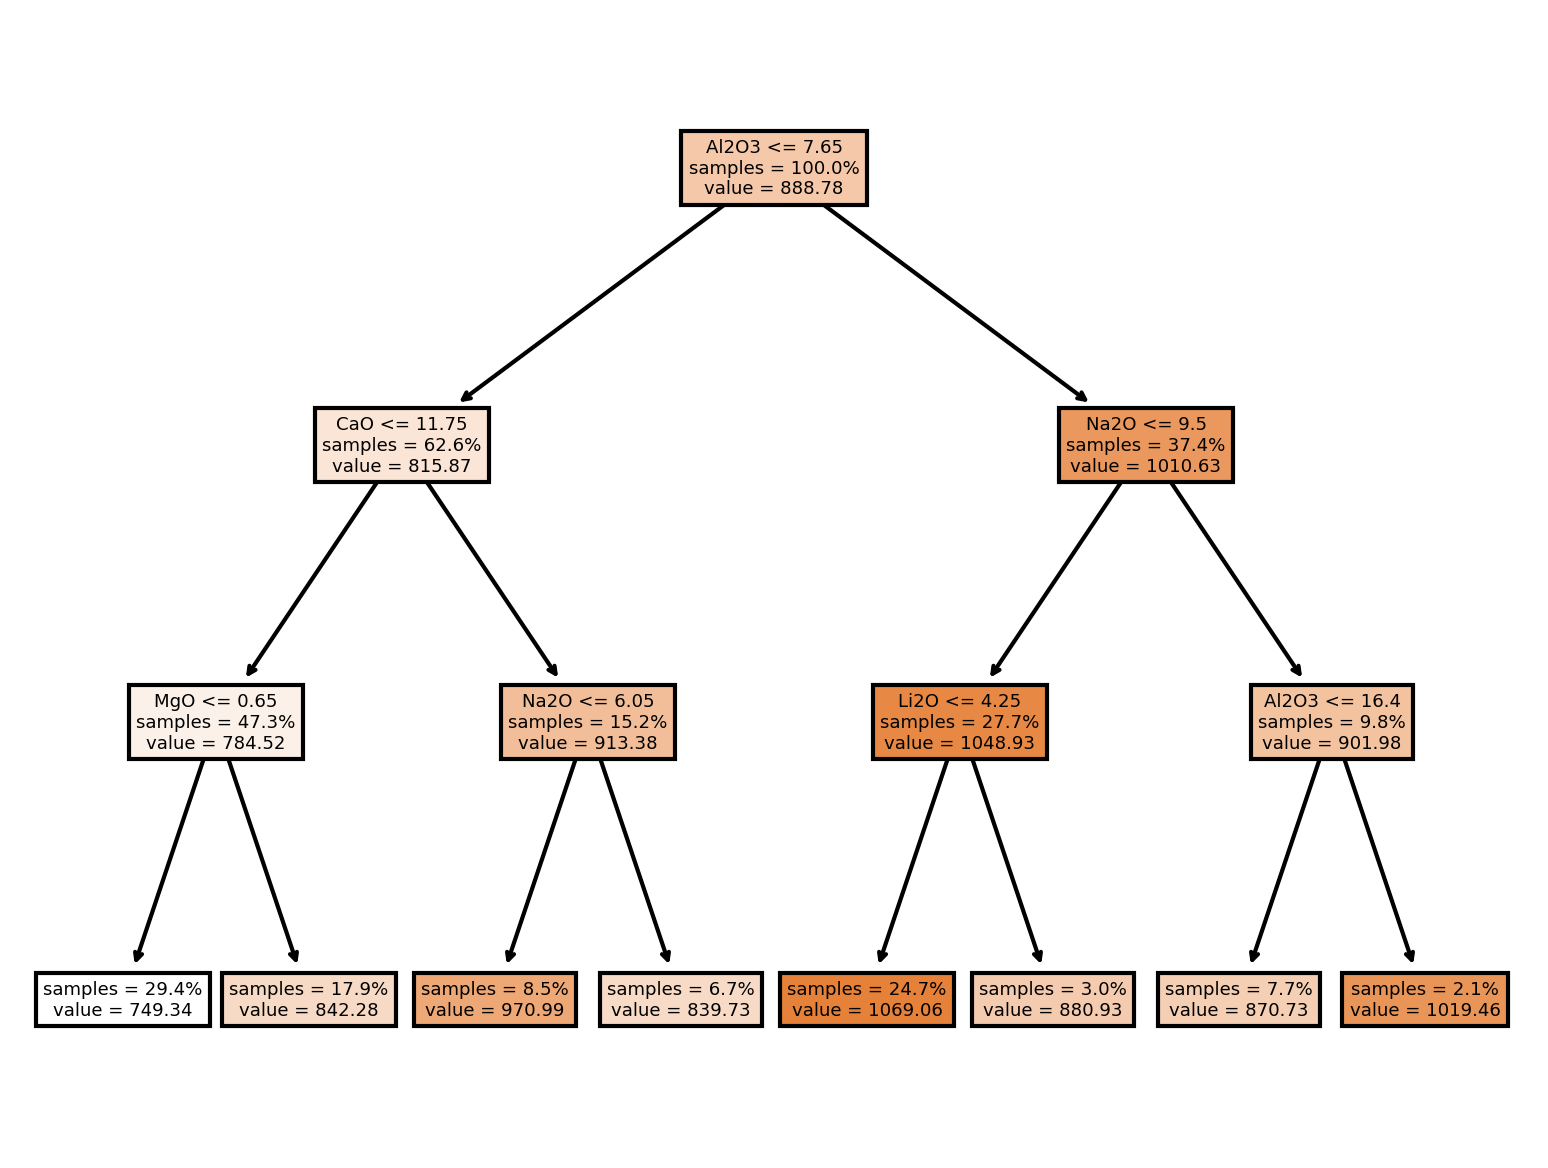

In [114]:
modelo = DecisionTreeRegressor(max_depth=3)
modelo.fit(X_treino, y_treino)

figura, eixo = plt.subplots(dpi=300)

tree.plot_tree(
    modelo,
    feature_names=X.columns.tolist(),
    ax=eixo,
    impurity=False,
    filled=True,
    proportion=True,
    precision=2,
)

print("Minha árvore de decisão:")

Podemos representar as decisões na forma de texto também.



In [115]:
texto = export_text(
    modelo,
    feature_names=X.columns.tolist(),
    decimals=2,
)

print(texto)

|--- Al2O3 <= 7.65
|   |--- CaO <= 11.75
|   |   |--- MgO <= 0.65
|   |   |   |--- value: [749.34]
|   |   |--- MgO >  0.65
|   |   |   |--- value: [842.28]
|   |--- CaO >  11.75
|   |   |--- Na2O <= 6.05
|   |   |   |--- value: [970.99]
|   |   |--- Na2O >  6.05
|   |   |   |--- value: [839.73]
|--- Al2O3 >  7.65
|   |--- Na2O <= 9.50
|   |   |--- Li2O <= 4.25
|   |   |   |--- value: [1069.06]
|   |   |--- Li2O >  4.25
|   |   |   |--- value: [880.93]
|   |--- Na2O >  9.50
|   |   |--- Al2O3 <= 16.40
|   |   |   |--- value: [870.73]
|   |   |--- Al2O3 >  16.40
|   |   |   |--- value: [1019.46]



#### Treinando uma árvore de decisão



Vamos treinar uma árvore de decisão.



In [116]:
modelo = DecisionTreeRegressor()
modelo.fit(X_treino, y_treino)

DecisionTreeRegressor()

Vamos estimar a performance do modelo.



In [117]:
y_verdadeiro = y_teste
y_previsao = modelo.predict(X_teste)

RMSE = mean_squared_error(y_verdadeiro, y_previsao, squared=False)

print(f"O RMSE do modelo árvore de decisão foi de {RMSE} unidades de y.")

O RMSE do modelo árvore de decisão foi de 42.16617540307476 unidades de y.


Uma forma de visualizar a performance é graficando o valor real versus o predito do target.



Text(0, 0.5, 'y previsto')

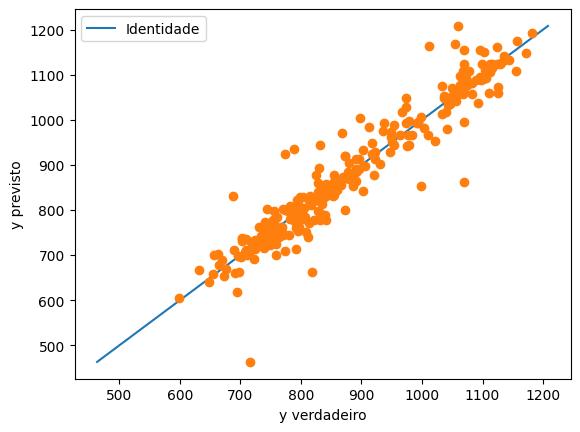

In [118]:
figura, eixo = plt.subplots()

x_plot = y_verdadeiro
y_plot = y_previsao

min_ = min(min(x_plot),min(y_plot))
max_ = max(max(x_plot),max(y_plot))

eixo.plot([min_,max_], [min_,max_], label="Identidade")

eixo.plot(
    x_plot,
    y_plot,
    marker="o",
    linestyle="none",
)

eixo.legend()

eixo.set_xlabel("y verdadeiro")
eixo.set_ylabel("y previsto")

### Treinando um modelo preditivo tipo floresta aleatória



O que é uma floresta aleatória?

Vamos treinar uma floresta aleatória.



In [119]:
modelo = RandomForestRegressor(random_state=61455)
modelo.fit(X_treino, y_treino)

RandomForestRegressor(random_state=61455)

Será que a performance é melhor do que a da árvore de decisão?



In [120]:
y_verdadeiro = y_teste
y_previsao = modelo.predict(X_teste)

RMSE = mean_squared_error(y_verdadeiro, y_previsao, squared=False)

print(f"O RMSE do modelo floresta aleatória foi de {RMSE} unidades de y.")

O RMSE do modelo floresta aleatória foi de 35.43033416038805 unidades de y.


Text(0, 0.5, 'y previsto')

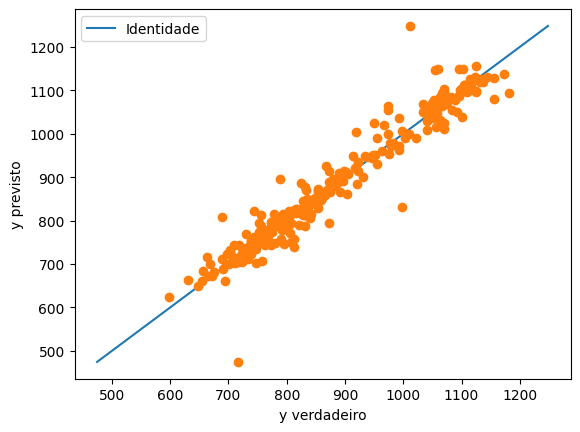

In [121]:
figura, eixo = plt.subplots()

x_plot = y_verdadeiro
y_plot = y_previsao

min_ = min(min(x_plot),min(y_plot))
max_ = max(max(x_plot),max(y_plot))

eixo.plot([min_,max_], [min_,max_], label="Identidade")

eixo.plot(
    x_plot,
    y_plot,
    marker="o",
    linestyle="none",
)

eixo.legend()

eixo.set_xlabel("y verdadeiro")
eixo.set_ylabel("y previsto")

<hr>



## Parte 3 - Aprendendo com o modelo



1.  Nem todos os modelos são interpretáveis como as árvores de decisão (conceito do modelo &ldquo;caixa-preta&rdquo;)

2.  Existem algoritmos que buscam estimar o impacto de cada atributo nas previsões dos modelos (exemplo: SHAP)

3.  Correlação não implica em causalidade



### Valores SHAP



Antes de seguir em frente, precisamos calcular os valores SHAP para cada material.



In [122]:
explicador = shap.explainers.Tree(modelo, X)
valores_shap = explicador(X)

 99%|===================| 2910/2927 [02:00<00:00]        

### Explicando uma previsão



Podemos avaliar o impacto de cada atributo na previsão do modelo.



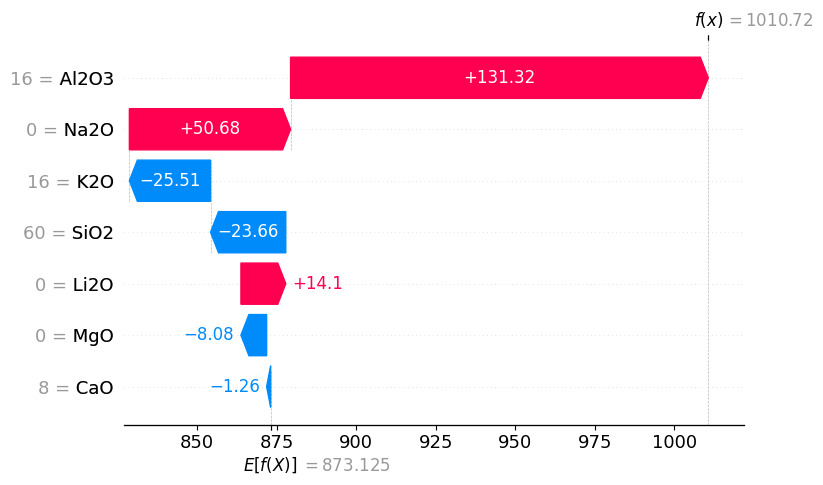

In [123]:
POS = 0

shap.plots.waterfall(valores_shap[POS])

### Os atributos de maior impacto



Podemos também checar quais são os atributos considerados mais importantes.



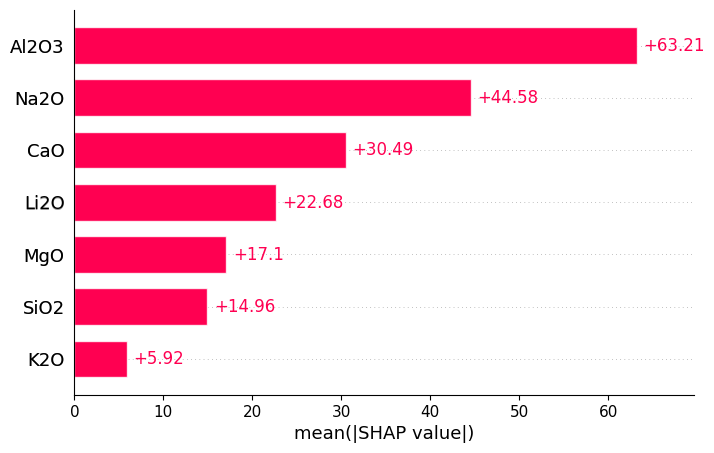

In [124]:
shap.plots.bar(valores_shap)

### Buscando correlações (que não são necessariamente causalidades!)



Finalmente, podemos também buscar correlações dentro de todo o conjunto de dados.



No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


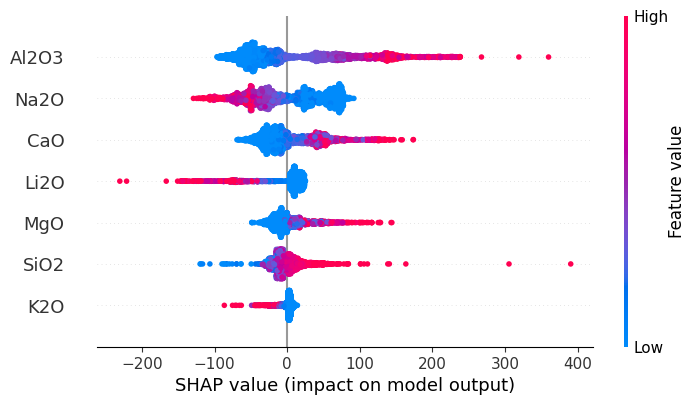

In [125]:
shap.plots.beeswarm(valores_shap)

<hr>



## Parte 4 - GlassNet



1.  Existem alguns modelos prontos (isto é, já treinados) para serem usados.

2.  GlassNet é uma rede neural multitarefa capaz de prever 85 propriedades de vidros e líquidos super-resfriados.

3.  GlassNet é um modelo livre disponível dentro do módulo `GlassPy`.



### Usando um modelo preditivo pronto (GlassNet)



Para usar o modelo, primeiro é necessário criar uma instância dele.



In [126]:
modelo = GlassNet()

Existem diversas formas de realizar uma previsão.



In [127]:
composicao = "SiO2"

previsao = modelo.predict(composicao)
previsao.T

,0
T0,2477.804380
T1,2414.232579
T2,2368.488917
T3,2303.035038
T4,2154.422485
...,...
SurfaceTensionAboveTg,0.308201
SurfaceTension1173K,0.066698
SurfaceTension1473K,0.347149
SurfaceTension1573K,0.274066


In [128]:
composicao = "Li2O(SiO2)2"

previsao = modelo.predict(composicao)
previsao.T

,0
T0,1656.661777
T1,1275.017006
T2,1178.333278
T3,1064.154863
T4,956.535513
...,...
SurfaceTensionAboveTg,0.322871
SurfaceTension1173K,0.299307
SurfaceTension1473K,0.326760
SurfaceTension1573K,0.314809


In [129]:
composicao = {
    "SiO2": 60,
    "Al2O3": 10,
    "Na2O": 30,
}

previsao = modelo.predict(composicao)
previsao.T

,0
T0,1980.469098
T1,1688.850355
T2,1433.135371
T3,1256.606065
T4,1136.053186
...,...
SurfaceTensionAboveTg,0.315217
SurfaceTension1173K,0.327083
SurfaceTension1473K,0.289456
SurfaceTension1573K,0.304983


Podemos realizar previsões de mais de um vidro ao mesmo tempo.



In [130]:
data = [
    [1, 0, 2],
    [0, 1, 2],
    [1, 1, 2],
]

composicoes = pd.DataFrame(data, columns=["Li2O", "Na2O", "SiO2"])
composicoes

,Li2O,Na2O,SiO2
0,1,0,2
1,0,1,2
2,1,1,2


In [131]:
previsao = modelo.predict(composicoes)
previsao.T

,0,1,2
T0,1656.662039,1766.656098,1556.850916
T1,1275.016943,1513.411310,1233.614128
T2,1178.333341,1279.021806,1101.165226
T3,1064.154863,1123.006920,979.065643
T4,956.535557,1035.724060,921.910502
...,...,...,...
SurfaceTensionAboveTg,0.322871,0.278585,0.299150
SurfaceTension1173K,0.299307,0.307567,0.303260
SurfaceTension1473K,0.326760,0.290559,0.320007
SurfaceTension1573K,0.314809,0.286678,0.318062


Podemos usar um DataFrame também, desde que ele tenha apenas colunas relativas à composição.



In [132]:
previsao = modelo.predict(X)
previsao.T

,0,1,2,3,4,5,6,7,8,9,...,2917,2918,2919,2920,2921,2922,2923,2924,2925,2926
T0,1906.896872,1932.430716,1919.639824,1907.704634,1896.618975,1828.391249,1680.298233,1789.119656,1685.051031,1819.264054,...,2072.492862,1848.900021,1930.906474,1968.257956,2056.588733,1740.159111,1879.551930,2068.741559,1699.841498,1927.317512
T1,1999.465312,1989.604181,1980.485469,1969.735871,1953.556705,1902.494910,1476.091098,1538.282322,1595.270152,1764.709251,...,1951.146255,1583.258468,1672.569512,1731.741746,1889.400659,1481.573786,1772.530126,1671.312371,1624.912369,1914.796284
T2,1776.538138,1757.895336,1747.616078,1738.019522,1721.705200,1679.715490,1260.927870,1301.995052,1365.781762,1514.901353,...,1737.802013,1374.182269,1451.925148,1500.389969,1645.957182,1311.187644,1514.042757,1549.311559,1385.122415,1665.940620
T3,1604.202723,1578.301736,1570.565103,1565.791077,1554.644200,1523.542543,1102.094965,1154.137537,1216.974030,1320.960285,...,1597.360574,1239.332661,1296.989697,1329.123227,1455.844248,1194.194254,1340.063797,1504.464623,1235.709713,1449.211549
T4,1487.394816,1457.900968,1442.578202,1430.560991,1415.996204,1387.714205,1017.051676,1024.674970,1119.714471,1199.797816,...,1448.876893,1125.920449,1170.972092,1201.540321,1311.405868,1117.287309,1213.995646,1320.645235,1148.183194,1325.742291
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SurfaceTensionAboveTg,0.322158,0.338020,0.339940,0.343484,0.345875,0.364433,0.266449,0.253526,0.310165,0.228301,...,0.326117,0.319416,0.318766,0.318423,0.320671,0.334804,0.322312,0.375615,0.279717,0.265622
SurfaceTension1173K,0.277181,0.284834,0.292989,0.298208,0.308452,0.321879,0.271725,0.261645,0.310861,0.236170,...,0.292765,0.324125,0.332423,0.333925,0.322970,0.338210,0.328287,0.255616,0.288882,0.249577
SurfaceTension1473K,0.293267,0.304813,0.304454,0.302977,0.301501,0.319629,0.253226,0.244817,0.308905,0.209961,...,0.290583,0.289253,0.289423,0.289622,0.289842,0.321514,0.310668,0.322160,0.293350,0.271651
SurfaceTension1573K,0.351330,0.360421,0.361883,0.362777,0.365393,0.390293,0.271549,0.241384,0.304172,0.218102,...,0.357144,0.312983,0.318167,0.322740,0.334361,0.332341,0.334374,0.357334,0.299974,0.258520


### Viscosidade com GlassNet



Viscosidade é uma das propriedades mais importantes para fabricação de vidros pois ela determina diversas temperaturas necessárias para o processo de manufatura.



In [133]:
composicao = "Li2O(SiO2)2"
temperatura = 1000

previsao = modelo.predict_log10_viscosity(
    T=temperatura,
    composition=composicao,
)
previsao

array([3.42916598])

Text(0, 0.5, 'Viscosidade ($\\log_{10}$ de Pa.s)')

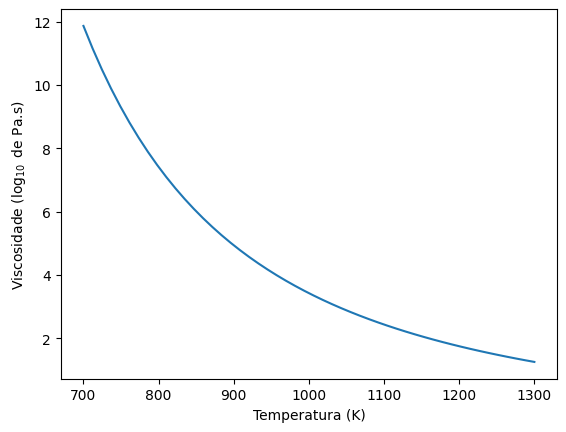

In [134]:
composicao = "Li2O(SiO2)2"
temperatura = np.linspace(700, 1300)

previsao = modelo.predict_log10_viscosity(
    T=temperatura,
    composition=composicao,
)

figura, eixo = plt.subplots()

eixo.plot(temperatura, previsao)

eixo.set_xlabel("Temperatura (K)")
eixo.set_ylabel("Viscosidade ($\log_{10}$ de Pa.s)")

<hr>



## Parte 5 - Inverse design



1.  O que é o projeto inverso?

2.  Como podemos resolver este problema?



### Código de base



O código abaixo usa o módulo `pymoo` junto com o modelo GlassNet para buscar novos vidros.

No código abaixo usamos uma busca genética já implementada no `pymoo`.



In [135]:
class Problema(Problem):
    def __init__(self, busca, modelo):
        num_compostos = len(busca["composição"]["compostos"])
        num_objetivos = len(busca["objetivos"])
        num_restricoes = len(busca.get("restrições", []))

        super().__init__(
            n_var=num_compostos,
            n_obj=num_objetivos,
            n_ieq_constr=num_restricoes,
            xl=busca["composição"]["mínimo"],
            xu=busca["composição"]["máximo"],
        )

        self.busca = busca
        self.modelo = modelo

    def _evaluate(self, entrada, saida, *args, **kwargs):
        compostos = self.busca["composição"]["compostos"]
        soma = self.busca["composição"]["soma"]

        x = to_array(entrada, compostos, rescale_to_sum=soma)

        propriedades = self.modelo.predict(x)

        saida["F"] = []
        for obj, stg in self.busca["objetivos"].items():
            saida["F"].append((-1 * stg * propriedades[obj]).values.ravel())

        if self.busca.get("restrições"):
            saida["G"] = []
            for obj, (tipo, valor) in self.busca["restrições"].items():
                index = compostos.index(obj)
                if tipo in [">", ">="]:
                    saida["G"].append(valor - x[:, index])
                elif tipo in ["<", "<="]:
                    saida["G"].append(x[:, index] - valor)


def busca_glassnet(busca):
    """Realiza o design inverso de um vidro."""

    modelo = GlassNet()

    compostos = busca["composição"]["compostos"]
    previsao = list(busca["objetivos"])
    soma = busca["composição"]["soma"]
    num_geracoes = busca["otimização"].get("num_gerações", 40)
    tam_populacao = busca["otimização"].get("tam_populacao", 40)

    problem = Problema(busca, modelo)

    algorithm = NSGA2(
        pop_size=tam_populacao,
        n_offsprings=int(tam_populacao / 4),
        sampling=FloatRandomSampling(),
        crossover=SBX(prob=0.9, eta=15),
        mutation=PM(eta=20),
        eliminate_duplicates=True,
    )

    termination = get_termination("n_gen", num_geracoes)

    res = minimize(
        problem,
        algorithm,
        termination,
        seed=1,
        save_history=True,
        verbose=True,
    )

    x = to_array(res.X, compostos, rescale_to_sum=soma)
    comp = pd.DataFrame(x, columns=compostos)

    prev = pd.DataFrame(res.F, columns=previsao)
    for nome, stg in busca["objetivos"].items():
        prev[nome] /= -stg

    df = pd.concat((comp, prev), axis=1)

    return df

### Configuração



As configurações fundamentais da busca são feitas na célula abaixo.



In [136]:
COMPOSTOS = ["SiO2", "Li2O", "K2O", "Na2O", "CuO", "MgO", "Cl2O3"]
MIN_COMP = 1
MAX_COMP = 99
SOMA_COMP = 100

### Problema de objetivo único (maximização)



In [137]:
configuracao_busca = {
    "composição": {
        "compostos": COMPOSTOS,
        "mínimo": MIN_COMP,
        "máximo": MAX_COMP,
        "soma": SOMA_COMP,
    },
    "objetivos": {
        "Microhardness": 1,
    },
    "otimização": {
        "num_gerações": 40,
        "tam_população": 40,
    },
}

In [138]:
resultado_busca = busca_glassnet(configuracao_busca)

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |       40 |      1 |             - |             -
     2 |       50 |      1 |  0.000000E+00 |             f
     3 |       60 |      1 |  0.000000E+00 |             f
     4 |       70 |      1 |  0.000000E+00 |             f
     5 |       80 |      1 |  0.2101943468 |         ideal
     6 |       90 |      1 |  0.000000E+00 |             f
     7 |      100 |      1 |  0.000000E+00 |             f
     8 |      110 |      1 |  0.0122716414 |         ideal
     9 |      120 |      1 |  0.000000E+00 |             f
    10 |      130 |      1 |  0.2983459587 |         ideal
    11 |      140 |      1 |  0.000000E+00 |             f
    12 |      150 |      1 |  0.000000E+00 |             f
    13 |      160 |      1 |  0.000000E+00 |             f
    14 |      170 |      1 |  0.000000E+00 |             f
    15 |      180 |      1 |  0.000000E+00 |             f
    16 |      190 |      1 |  0.000000E+00 |            

In [139]:
resultado_busca

,SiO2,Li2O,K2O,Na2O,CuO,MgO,Cl2O3,Microhardness
0,10.255488,13.370532,1.243513,3.034809,12.154215,58.882872,1.058571,8.618891


### Problema de objetivo único (minimização)



In [140]:
configuracao_busca = {
    "composição": {
        "compostos": COMPOSTOS,
        "mínimo": MIN_COMP,
        "máximo": MAX_COMP,
        "soma": SOMA_COMP,
    },
    "objetivos": {
        "Microhardness": -1,
    },
    "otimização": {
        "num_gerações": 40,
        "tam_população": 40,
    },
}

In [141]:
resultado_busca = busca_glassnet(configuracao_busca)

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |       40 |      1 |             - |             -
     2 |       50 |      1 |  0.000000E+00 |             f
     3 |       60 |      1 |  0.000000E+00 |             f
     4 |       70 |      1 |  0.000000E+00 |             f
     5 |       80 |      1 |  0.000000E+00 |             f
     6 |       90 |      1 |  0.2936650301 |         ideal
     7 |      100 |      1 |  0.000000E+00 |             f
     8 |      110 |      1 |  0.000000E+00 |             f
     9 |      120 |      1 |  0.0015162153 |             f
    10 |      130 |      1 |  0.8661776614 |         ideal
    11 |      140 |      1 |  0.000000E+00 |             f
    12 |      150 |      1 |  0.7115223911 |         ideal
    13 |      160 |      1 |  0.000000E+00 |             f
    14 |      170 |      1 |  0.000000E+00 |             f
    15 |      180 |      1 |  0.000000E+00 |             f
    16 |      190 |      1 |  0.000000E+00 |            

In [142]:
resultado_busca

,SiO2,Li2O,K2O,Na2O,CuO,MgO,Cl2O3,Microhardness
0,0.690438,0.81406,48.546044,46.769937,0.769144,1.80809,0.602287,1.311983


### Problema de objetivo único com restrição



In [143]:
configuracao_busca = {
    "composição": {
        "compostos": COMPOSTOS,
        "mínimo": MIN_COMP,
        "máximo": MAX_COMP,
        "soma": SOMA_COMP,
    },
    "objetivos": {
        "Microhardness": 1,
    },
    "restrições": {
        "SiO2": (">", 60),
    },
    "otimização": {
        "num_gerações": 40,
        "tam_população": 40,
    },
}

In [144]:
resultado_busca = busca_glassnet(configuracao_busca)

n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |       40 |      1 |  1.718941E+01 |  4.558599E+01 |             - |             -
     2 |       50 |      1 |  1.718941E+01 |  4.157372E+01 |             - |             -
     3 |       60 |      1 |  1.718941E+01 |  3.893569E+01 |             - |             -
     4 |       70 |      1 |  1.718941E+01 |  3.686668E+01 |             - |             -
     5 |       80 |      1 |  1.718941E+01 |  3.526969E+01 |             - |             -
     6 |       90 |      1 |  1.718941E+01 |  3.373323E+01 |             - |             -
     7 |      100 |      1 |  1.718941E+01 |  3.257499E+01 |             - |             -
     8 |      110 |      1 |  1.718941E+01 |  3.102837E+01 |             - |             -
     9 |      120 |      1 |  7.4438700952 |  2.912965E+01 |             - |             -
    10 |      130 |      1 |  7.4438700952 |  2.710069E+01 |             - |             -

In [145]:
resultado_busca

,SiO2,Li2O,K2O,Na2O,CuO,MgO,Cl2O3,Microhardness
0,61.616393,14.665519,0.785793,1.22507,3.682271,17.189095,0.835859,7.197103


### Problema multiobjetivo com restrições



In [146]:
configuracao_busca = {
    "composição": {
        "compostos": COMPOSTOS,
        "mínimo": MIN_COMP,
        "máximo": MAX_COMP,
        "soma": SOMA_COMP,
    },
    "objetivos": {
        "Microhardness": -1,
        "RefractiveIndex": 1,
        "AbbeNum": 1,
    },
    "restrições": {
        "SiO2": (">", 60),
        "Al2O3": ("<", 10),
    },
    "otimização": {
        "num_gerações": 40,
        "tam_população": 40,
    },
}

In [147]:
resultado_busca = busca_glassnet(configuracao_busca)

ValueError: 'Al2O3' is not in list

In [ ]:
resultado_busca

,SiO2,Li2O,K2O,Na2O,CaO,MgO,Al2O3,Microhardness,RefractiveIndex,AbbeNum
0,60.773568,2.610796,0.435848,14.038843,4.143728,16.796977,1.200240,5.693189,1.500166,57.737746
1,66.313111,5.485232,9.138783,1.909447,16.989604,0.048451,0.115372,5.776121,1.521019,58.006444
2,65.207910,2.760297,2.034542,1.773757,1.280394,20.172958,6.770141,6.188005,1.497185,61.685569
3,69.377999,2.743535,0.568231,1.205964,0.582976,18.566712,6.954582,6.152461,1.493592,61.960872
4,72.627953,7.414876,16.450953,1.683011,0.283814,0.047994,1.491400,5.105119,1.494861,59.029141
5,93.020756,3.458168,0.900468,2.107939,0.384188,0.053379,0.075102,5.504015,1.471336,60.510376
6,69.469986,1.687198,13.138760,1.530244,2.857731,8.580606,2.735475,5.465849,1.485601,59.939846
7,71.206042,7.264159,16.116566,1.653987,0.278046,0.047018,3.434182,5.197691,1.495633,59.049386
8,60.262246,8.162560,1.917578,2.151690,12.208113,9.082455,6.215357,6.072030,1.510509,58.277100
9,62.003743,4.111564,12.027108,2.043383,13.773505,0.447237,5.593461,5.733268,1.516860,57.861577


<hr>



## Referências



1.  [https://numpy.org/](https://numpy.org/)

2.  [https://scipy.org/](https://scipy.org/)

3.  [https://pandas.pydata.org/](https://pandas.pydata.org/)

4.  [https://matplotlib.org/](https://matplotlib.org/)

5.  [https://scikit-learn.org/](https://scikit-learn.org/)

6.  [https://pymoo.org/](https://pymoo.org/)

7.  [https://shap.readthedocs.io/](https://shap.readthedocs.io/)

8.  [https://glasspy.readthedocs.io/](https://glasspy.readthedocs.io/)

9.  Kaufman, S., Rosset, S., Perlich, C., and Stitelman, O. (2012). Leakage in data mining: Formulation, detection, and avoidance. ACM Trans. Knowl. Discov. Data 6, 15:1-15:21. 10.1145/2382577.2382579.

10. Cassar, D.R. (2023). GlassNet: A multitask deep neural network for predicting many glass properties. Ceramics International. 10.1016/j.ceramint.2023.08.281.

11. Lundberg, S.M., and Lee, S.-I. (2017). A unified approach to interpreting model predictions. Advances in Neural Information Processing Systems 30, 4765–4774.

